In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import random
import torch
import torch.nn.functional as nnf
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from dataset_class import PatchShuffled_CIFAR10

def shuffle(patch_size: int, data_point):
    # Image of size (img_dim x img_dim), img_dim should be divisible by patch_size, and data shape should be channel-last HxWxC
    height_reshape= int(np.shape(data_point)[0]/patch_size)
    img = rearrange(data_point, '(h s1) (w s2) c -> (h w) s1 s2 c', s1=patch_size, s2=patch_size)
    np.random.shuffle(img)
    img = rearrange(img, '(h w) s1 s2 c -> (h s1) (w s2) c', h=height_reshape, s1=patch_size, s2=patch_size)
    return img


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

def create_patch_shuffled_data(dataset: torchvision.datasets, file_name: str) -> None:
    images = []
    labels = []
    for i in range(25): # 25
        m = np.asarray(dataset[i][0])
        images.append(m)
        labels.append(i+1)
        m1 = shuffle(patch_size=16, data_point=m)
        images.append(m1)
        labels.append(i+1)
        m2 = shuffle(patch_size=8, data_point=m)
        images.append(m2)
        labels.append(i+1)

    np.savez(file=file_name, data=images, labels=labels)


Files already downloaded and verified


In [2]:
# Create patch shuffled data
create_patch_shuffled_data(testset, "patch_shuffled_data.npz")

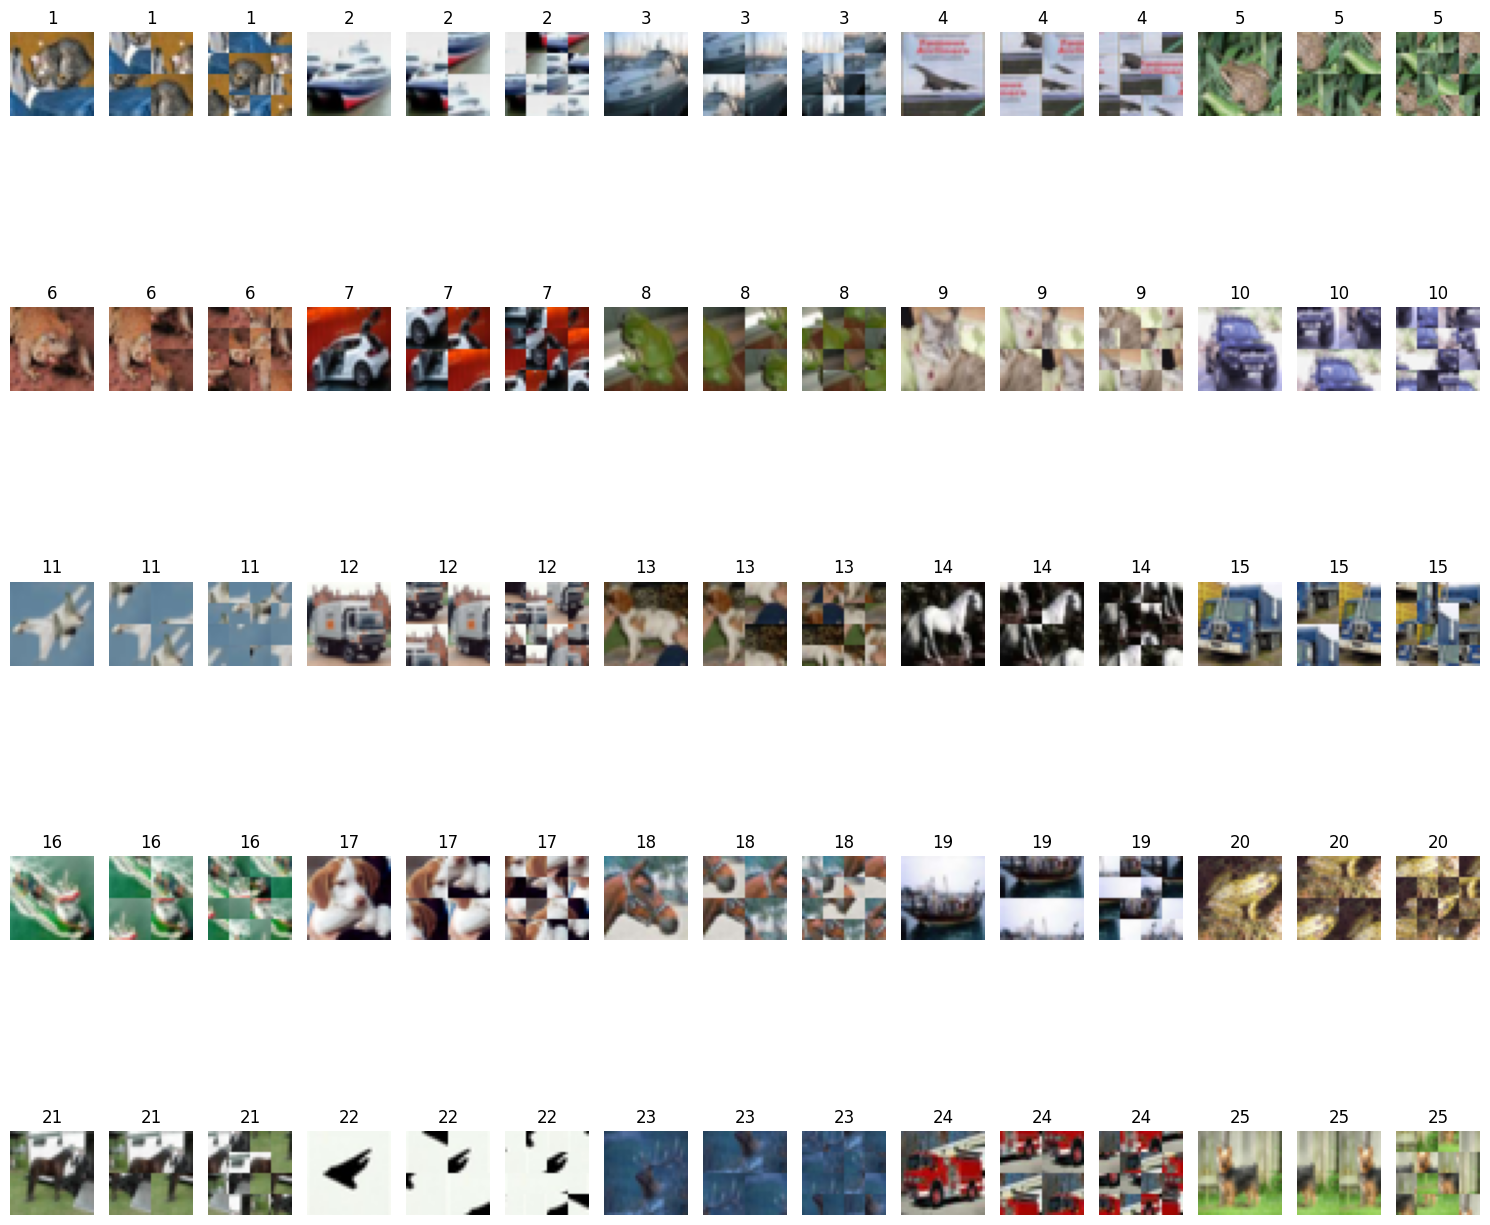

In [3]:
def plot_saved_images(file_name: str):
    # Load data from the npz file
    data = np.load(file_name)
    images = data['data']
    labels = data['labels']

    # Define the number of rows and columns for the grid
    num_images = len(images)
    rows = 5
    cols = 15

    # Create the plot grid
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    # Flatten the axes array to easily iterate over the subplots
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"{labels[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the saved images
plot_saved_images("patch_shuffled_data.npz")

In [4]:
# Referred to https://github.com/bentrevett/pytorch-image-classification/blob/master/4_vgg.ipynb
from main import Net_D_shuffletruffle, Net_N_shuffletruffle, Net
from sklearn.decomposition import PCA
from torchvision import datasets
from sklearn import decomposition
from tqdm import tqdm

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4913, 0.4822, 0.4467), (0.2114, 0.2088, 0.2122))
    ])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Load the datasets
testset = datasets.CIFAR10(root='./data', train=False, download=True)
testset = PatchShuffled_CIFAR10(data_file_path = f'patch_shuffled_data.npz', transforms = transform)
testloader = DataLoader(testset, batch_size=25, shuffle=False)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(0))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size= 64, shuffle=True)

net = Net()
net_d_shuffletruffle = Net_D_shuffletruffle()
net_n_shuffletruffle = Net_N_shuffletruffle()

def get_representations(model, iterator):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, labels

outputsNet, labelsNet = get_representations(net, testloader)
outputsDST, labelsDST = get_representations(net_d_shuffletruffle, testloader)
outputsNST, labelsNST = get_representations(net_n_shuffletruffle, testloader)

def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 3/3 [00:00<00:00, 47.74it/s]


[<matplotlib.lines.Line2D object at 0x000002A9D85F7DD0>, <matplotlib.lines.Line2D object at 0x000002A9D8657B50>, <matplotlib.lines.Line2D object at 0x000002A9D8664290>, <matplotlib.lines.Line2D object at 0x000002A9D86648D0>, <matplotlib.lines.Line2D object at 0x000002A9D8656150>, <matplotlib.lines.Line2D object at 0x000002A9D86652D0>, <matplotlib.lines.Line2D object at 0x000002A9D86657D0>, <matplotlib.lines.Line2D object at 0x000002A9D8665D10>]


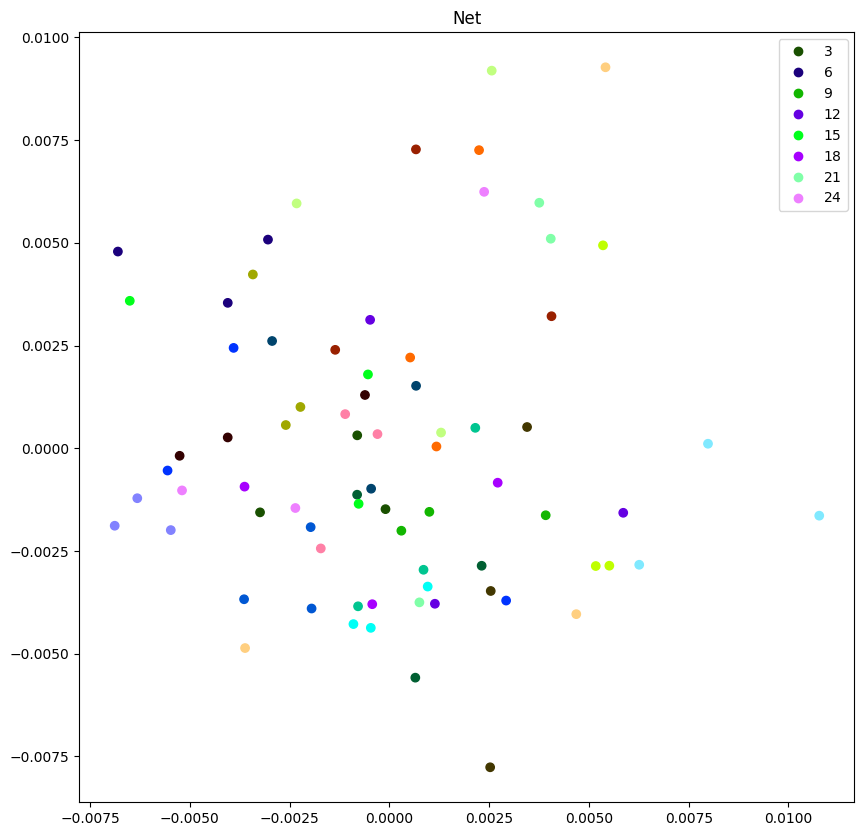

[<matplotlib.lines.Line2D object at 0x000002A9D8ECE5D0>, <matplotlib.lines.Line2D object at 0x000002A9D8EDEBD0>, <matplotlib.lines.Line2D object at 0x000002A9D8EDE9D0>, <matplotlib.lines.Line2D object at 0x000002A9D8EDFA10>, <matplotlib.lines.Line2D object at 0x000002A9D8EDEAD0>, <matplotlib.lines.Line2D object at 0x000002A9D8EDDD10>, <matplotlib.lines.Line2D object at 0x000002A9D8EDFA90>, <matplotlib.lines.Line2D object at 0x000002A9D8EDDE10>]


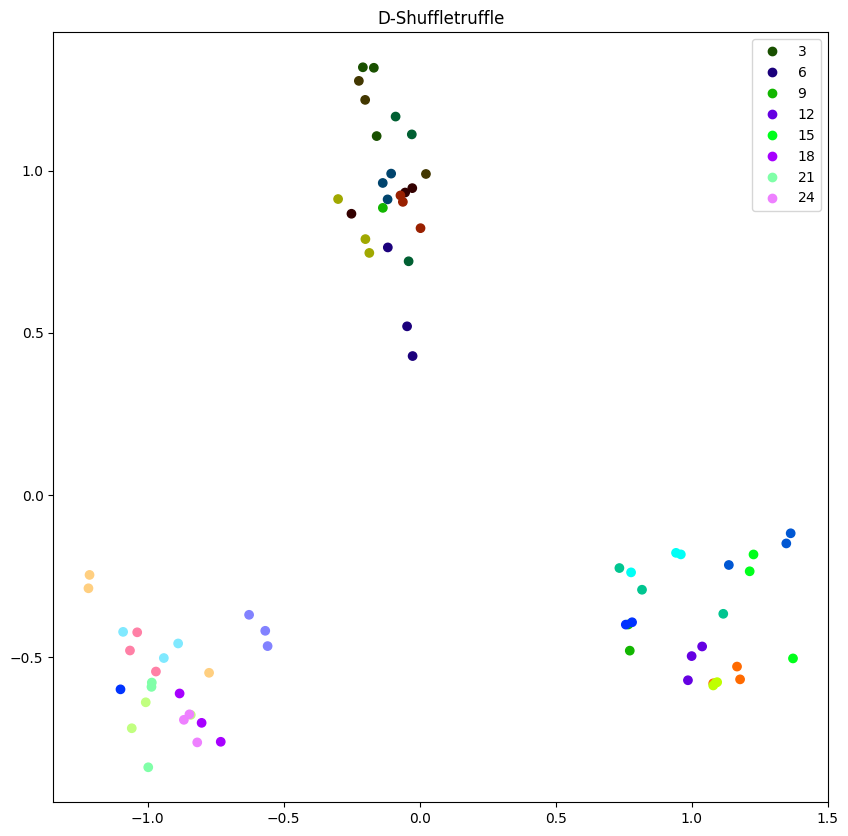

[<matplotlib.lines.Line2D object at 0x000002A9D8F9A510>, <matplotlib.lines.Line2D object at 0x000002A9D8F840D0>, <matplotlib.lines.Line2D object at 0x000002A9D8F84910>, <matplotlib.lines.Line2D object at 0x000002A9D8F86D50>, <matplotlib.lines.Line2D object at 0x000002A9D8F85950>, <matplotlib.lines.Line2D object at 0x000002A9D8F84B90>, <matplotlib.lines.Line2D object at 0x000002A9D8F688D0>, <matplotlib.lines.Line2D object at 0x000002A9D8F683D0>]


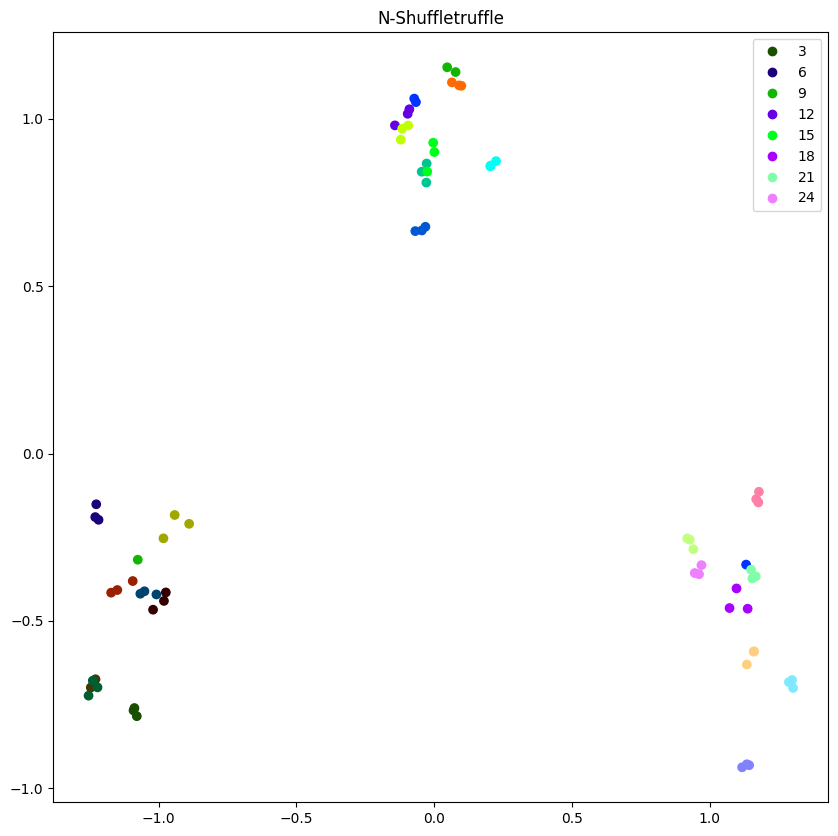

In [5]:
from matplotlib.colors import ListedColormap
import math 
from matplotlib.cm import hsv
def generate_colormap(number_of_distinct_colors: int = 25):
    # generates color maps (adopted from https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours)
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

# Function to plot representations
def plot_representations(data, labels, classes, title, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=generate_colormap(25))

    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)
    print(handles)
    ax.set_title(title)
    plt.show()

# Compute PCA for the outputs
output_pca_data = get_pca(outputsNet)
dst_pca_data = get_pca(outputsDST)
nst_pca_data = get_pca(outputsNST)

# Plot the representations for each network with titles
plot_representations(output_pca_data, labelsNet, [i for i in range(1, 26)], "Net", n_images=None)
plot_representations(dst_pca_data, labelsDST, [i for i in range(1, 26)], "D-Shuffletruffle", n_images=None)
plot_representations(nst_pca_data, labelsNST, [i for i in range(1, 26)], "N-Shuffletruffle", n_images=None)